# Convergence analysis for the standing mode example

Data for the standing mode wave:
$$
\begin{aligned}
&\textbf{Domain:} && \Omega = [0, 1] \times [0, 1] \\
&\textbf{Final time:} && T = 1.0 \\
&\textbf{Number of elements:} && N_{\text{el},x} = N_{\text{el},y} = 320 \\
&\textbf{Polynomial degree:} && r = 1 \\
&\textbf{Time step:} && \Delta t = 0.01 \\
&\textbf{Wave speed:} && c(x, y, t) = 1.0 \\
&\textbf{Source:} && f(x, y, t) = 0 \\
&\textbf{Initial displacement:} && u_0(x, y) = \sin(\pi x)\sin(\pi y) \\
&\textbf{Initial velocity:} && v_0(x, y) = 0 \\
&\textbf{Boundary conditions:} && g(x, y, t) = 0 \\
&\textbf{Time derivative of boundary:} && \frac{\partial g}{\partial t}(x, y, t) = 0 \\
&\textbf{Exact solution:} && u_{\text{exact}}(x, y, t) = \cos(\sqrt{2}\pi t)\sin(\pi x)\sin(\pi y) \\
\end{aligned}
$$


## Newmark

Diverging configurations are not shown in the plots.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.colors as colors
import numpy as np

sns.set_theme(style="whitegrid")

# Threshold for flagging divergence
DIVERGENCE_THRESHOLD = 1.0e5

In [12]:
def filter_diverged(df, threshold=DIVERGENCE_THRESHOLD):
    """
    Remove rows where error >= threshold and report diverged configurations.
    Returns cleaned dataframe and list of diverged configs.
    """
    df = df.copy()
    diverged = []
    
    for col in ['rel_L2_error_final', 'rel_H1_error_final']:
        if col in df.columns:
            # Handle NaN and inf
            df[col] = df[col].replace([np.inf, -np.inf], threshold * 10)
            df[col] = df[col].fillna(threshold * 10)
    
    # Find diverged rows
    mask_diverged = (df['rel_L2_error_final'] >= threshold) | (df['rel_H1_error_final'] >= threshold)
    if mask_diverged.any():
        diverged = df[mask_diverged][['N_el_x', 'N_el_y', 'r', 'dt']].drop_duplicates().values.tolist()
    
    # Return cleaned (non-diverged) dataframe
    return df[~mask_diverged], diverged

def plot_lines_by_r(df, scheme_name, r_per_row=2):
    """Single-row layout (4x1 for r_per_row=2), grouped by metric: L2 then H1."""
    df_clean, diverged = filter_diverged(df)
    figs_local = []
    if df_clean.empty or 'r' not in df_clean.columns:
        return figs_local

    r_vals = sorted(df_clean['r'].unique())
    for k in range(0, len(r_vals), r_per_row):
        r_group = r_vals[k:k + r_per_row]
        ncols = len(r_group)

        fig, axes = plt.subplots(1, 2 * ncols, figsize=(5 * 2 * ncols, 5), sharex=False, sharey=False)
        axes = np.array(axes).reshape(1, -1)

        # Axes groups: share y within L2 and within H1
        l2_axes = [axes[0, j] for j in range(ncols)]
        h1_axes = [axes[0, ncols + j] for j in range(ncols)]
        for ax in l2_axes[1:]:
            ax.sharey(l2_axes[0])
        for ax in h1_axes[1:]:
            ax.sharey(h1_axes[0])

        for j, r_val in enumerate(r_group):
            sub = df_clean[df_clean['r'] == r_val].copy()
            if sub.empty:
                continue
            sub['h_label'] = sub['h'].astype(str)

            # Order: [L2(r1), L2(r2), ..., H1(r1), H1(r2), ...]
            ax_l2 = l2_axes[j]
            ax_h1 = h1_axes[j]

            l2_legend = 'full' if (j == 0) else False
            sns.lineplot(
                data=sub, x='dt', y='rel_L2_error_final',
                hue='h_label', style='h_label', dashes=False,
                ax=ax_l2, legend=l2_legend, linewidth=2, marker="o"
            )
            sns.lineplot(
                data=sub, x='dt', y='rel_H1_error_final',
                hue='h_label', style='h_label', dashes=False,
                ax=ax_h1, legend=False, linewidth=2, marker="o"
            )

            ax_l2.set_title(f'L2 (r={r_val})')
            ax_h1.set_title(f'H1 (r={r_val})')

            # Scales + x labels
            for ax in (ax_l2, ax_h1):
                ax.set_xscale('log'); ax.set_yscale('log')
                ax.set_xlabel('dt')

            # Keep only ONE y-label per metric group
            ax_l2.set_ylabel('rel L2 error' if j == 0 else '')
            ax_h1.set_ylabel('rel H1 error' if j == 0 else '')

        # Enforce identical y-limits within each metric (per r_group)
        sub_all = df_clean[df_clean['r'].isin(r_group)]
        l2v = sub_all['rel_L2_error_final'].to_numpy()
        l2v = l2v[np.isfinite(l2v) & (l2v > 0)]
        if l2v.size:
            lo, hi = float(l2v.min()), float(l2v.max())
            for ax in l2_axes:
                ax.set_ylim(lo * 0.8, hi * 1.25)
        h1v = sub_all['rel_H1_error_final'].to_numpy()
        h1v = h1v[np.isfinite(h1v) & (h1v > 0)]
        if h1v.size:
            lo, hi = float(h1v.min()), float(h1v.max())
            for ax in h1_axes:
                ax.set_ylim(lo * 0.8, hi * 1.25)

        # One legend below, dedup labels
        leg_ax = axes[0, 0]
        handles, labels = leg_ax.get_legend_handles_labels()
        if leg_ax.get_legend() is not None:
            leg_ax.get_legend().remove()
        for ax in axes.ravel():
            if ax.get_legend() is not None:
                ax.get_legend().remove()
        uniq = []
        seen = set()
        for h, l in zip(handles, labels):
            if l == 'h_label':
                continue
            if l in seen:
                continue
            seen.add(l)
            uniq.append((h, l))
        if uniq:
            h2, l2 = zip(*uniq)
            fig.legend(
                h2, l2, title='h',
                loc='lower center', bbox_to_anchor=(0.5, -0.02),
                ncol=min(len(l2), 6), frameon=True,
                borderaxespad=0.1, columnspacing=0.8, handletextpad=0.4
            )

        fig.suptitle(f'{scheme_name}: Error vs dt', y=0.9)
        fig.tight_layout(rect=[0, 0.06, 1, 0.94])
        figs_local.append(fig)
    return figs_local

def plot_heatmaps(df, scheme_name, r_per_row=2):
    """Single-row layout: group by metric (L2 then H1) + ONE shared colorbar."""
    df_clean, diverged = filter_diverged(df)
    if df_clean.empty:
        print(f"  (No valid data to plot after filtering)")
        return

    # Shared scale (report-friendly): one norm + one colorbar for both L2 and H1
    l2_min = df_clean['rel_L2_error_final'].min(); l2_max = df_clean['rel_L2_error_final'].max()
    h1_min = df_clean['rel_H1_error_final'].min(); h1_max = df_clean['rel_H1_error_final'].max()
    err_min = min(l2_min, h1_min)
    err_max = max(l2_max, h1_max)
    shared_norm = colors.LogNorm(vmin=err_min, vmax=err_max)

    r_vals = sorted(df_clean['r'].unique())
    for k in range(0, len(r_vals), r_per_row):
        r_group = r_vals[k:k + r_per_row]
        ncols = len(r_group)

        fig, axes = plt.subplots(1, 2 * ncols, figsize=(5 * 2 * ncols + 2, 4), sharex=False, sharey=True)
        axes = np.array(axes).reshape(1, -1)

        # Grouping: [L2(r1), L2(r2), ..., H1(r1), H1(r2), ...]
        l2_axes = [axes[0, j] for j in range(ncols)]
        h1_axes = [axes[0, ncols + j] for j in range(ncols)]

        for j, r_val in enumerate(r_group):
            sub = df_clean[df_clean['r'] == r_val].copy()
            if sub.empty:
                continue

            pivot_l2 = sub.pivot_table(index='h', columns='dt', values='rel_L2_error_final')
            pivot_h1 = sub.pivot_table(index='h', columns='dt', values='rel_H1_error_final')

            ax_l2 = l2_axes[j]
            ax_h1 = h1_axes[j]

            sns.heatmap(pivot_l2, ax=ax_l2, cmap='magma', norm=shared_norm, cbar=False)
            sns.heatmap(pivot_h1, ax=ax_h1, cmap='magma', norm=shared_norm, cbar=False)

            ax_l2.set_title(f'L2 (r={r_val})', fontsize=10)
            ax_h1.set_title(f'H1 (r={r_val})', fontsize=10)
            ax_l2.set_xlabel('dt'); ax_h1.set_xlabel('dt')
            ax_l2.set_ylabel('h' if j == 0 else '')
            ax_h1.set_ylabel('')

        # Small scheme title (like the lineplots)
        fig.suptitle(scheme_name, y=0.96, fontsize=12)

        # Tight intra-group spacing + small inter-group gap
        fig.subplots_adjust(top=0.86, right=0.86, wspace=0.08)
        group_gap = 0.03
        for ax in h1_axes:
            pos = ax.get_position()
            ax.set_position([pos.x0 + group_gap, pos.y0, pos.width, pos.height])

        # Shared colorbar (placed to the right of the shifted H1 group)
        sm = plt.cm.ScalarMappable(cmap='magma', norm=shared_norm)
        sm.set_array([])
        right_edge = max(ax.get_position().x1 for ax in h1_axes) if h1_axes else 0.86
        cax = fig.add_axes([min(0.97, right_edge + 0.02), 0.15, 0.02, 0.7])
        fig.colorbar(sm, cax=cax, label='relative error')

In [13]:
csv_path = Path('convergence-newmark.csv')
df_newmark = pd.read_csv(csv_path)
# Drop duplicates keeping the last entry
df_newmark = df_newmark.drop_duplicates(subset=['h', 'N_el_x', 'N_el_y', 'r', 'dt', 'T', 'method', 'beta', 'gamma'], keep='last')

# Subsets for Newmark: beta = 0.25 and beta = 0.0
df_newmark_025 = df_newmark[df_newmark['beta'] == 0.25].copy()
df_newmark_000 = df_newmark[df_newmark['beta'] == 0.0].copy()
print('=== Newmark ===\n- beta=0.25 rows:', len(df_newmark_025), '\n- beta=0.0  rows:', len(df_newmark_000))

=== Newmark ===
- beta=0.25 rows: 50 
- beta=0.0  rows: 50


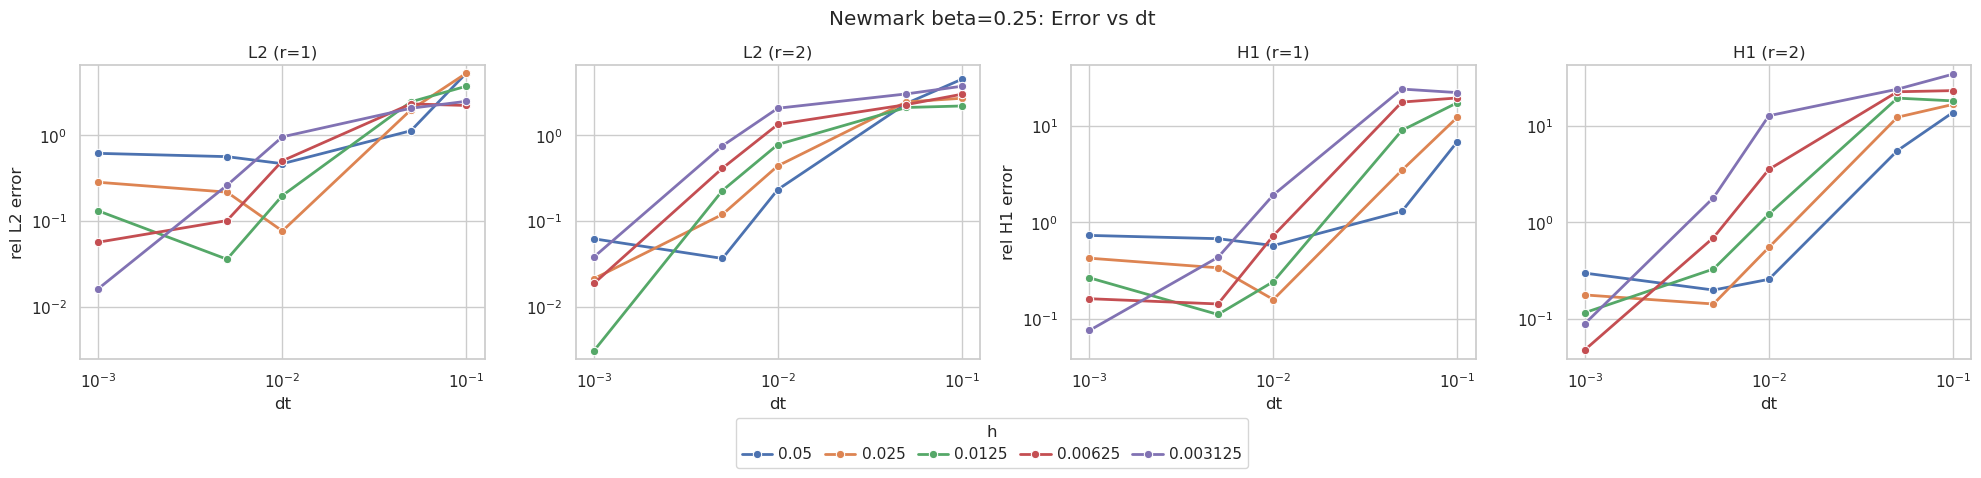

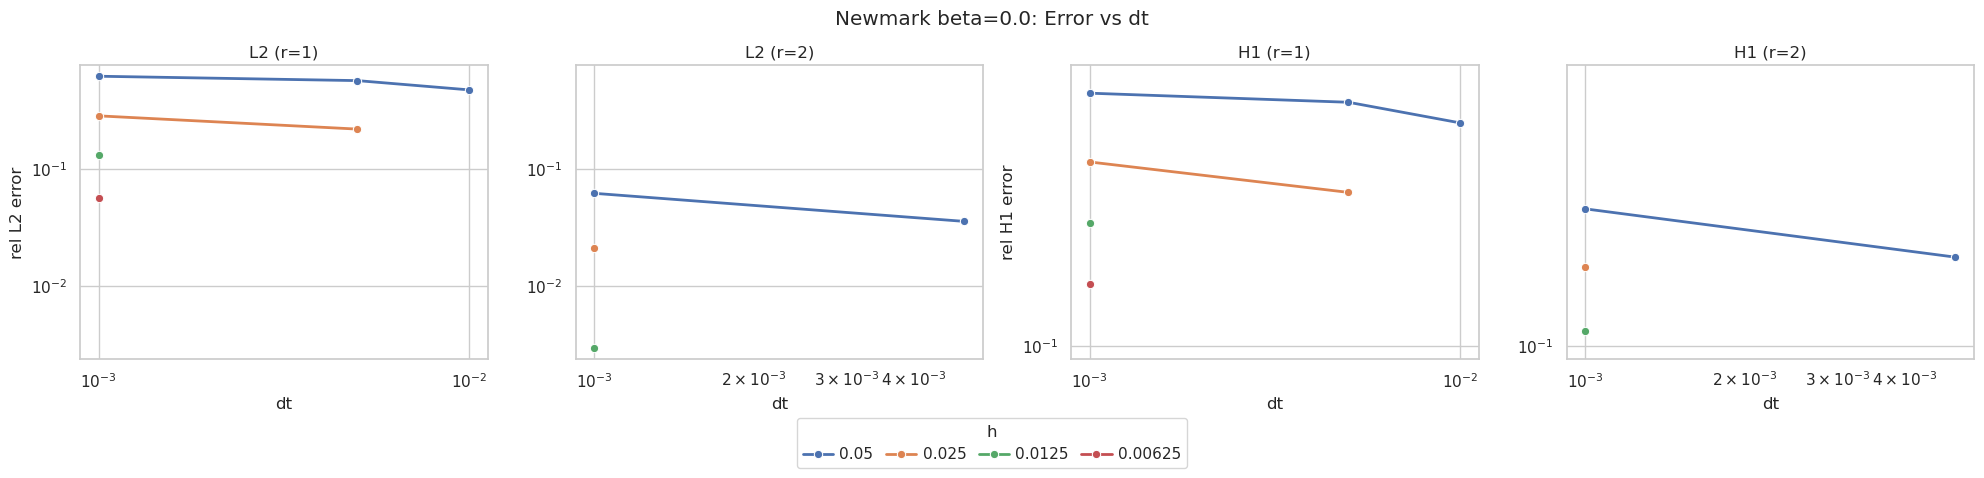

In [14]:
# Line charts for Newmark subsets
figs_nmk_025 = plot_lines_by_r(df_newmark_025, 'Newmark beta=0.25')
print()
figs_nmk_000 = plot_lines_by_r(df_newmark_000, 'Newmark beta=0.0')

In [15]:
# # Heatmaps for Newmark subsets
# plot_heatmaps(df_newmark_025, 'Newmark beta=0.25')
# print()
# plot_heatmaps(df_newmark_000, 'Newmark beta=0.0')

## Theta

In [16]:
csv_path_theta = Path('convergence-theta.csv')
df_theta = pd.read_csv(csv_path_theta)
# Drop duplicates keeping the last entry
df_theta = df_theta.drop_duplicates(subset=['h', 'N_el_x', 'N_el_y', 'r', 'dt', 'T', 'method', 'theta'], keep='last')

# Subsets per request: theta = 1.0 (BE), theta = 0.5 (CN), theta = 0.0 (FE)
df_theta_BE = df_theta[df_theta['theta'] == 1.0].copy()
df_theta_CN = df_theta[df_theta['theta'] == 0.5].copy()
df_theta_FE = df_theta[df_theta['theta'] == 0.0].copy()
print('=== Theta ===\n- FE (theta=0.0) rows:', len(df_theta_FE), '\n- CN (theta=0.5) rows:', len(df_theta_CN), '\n- BE (theta=1.0) rows:', len(df_theta_BE))

=== Theta ===
- FE (theta=0.0) rows: 50 
- CN (theta=0.5) rows: 50 
- BE (theta=1.0) rows: 50


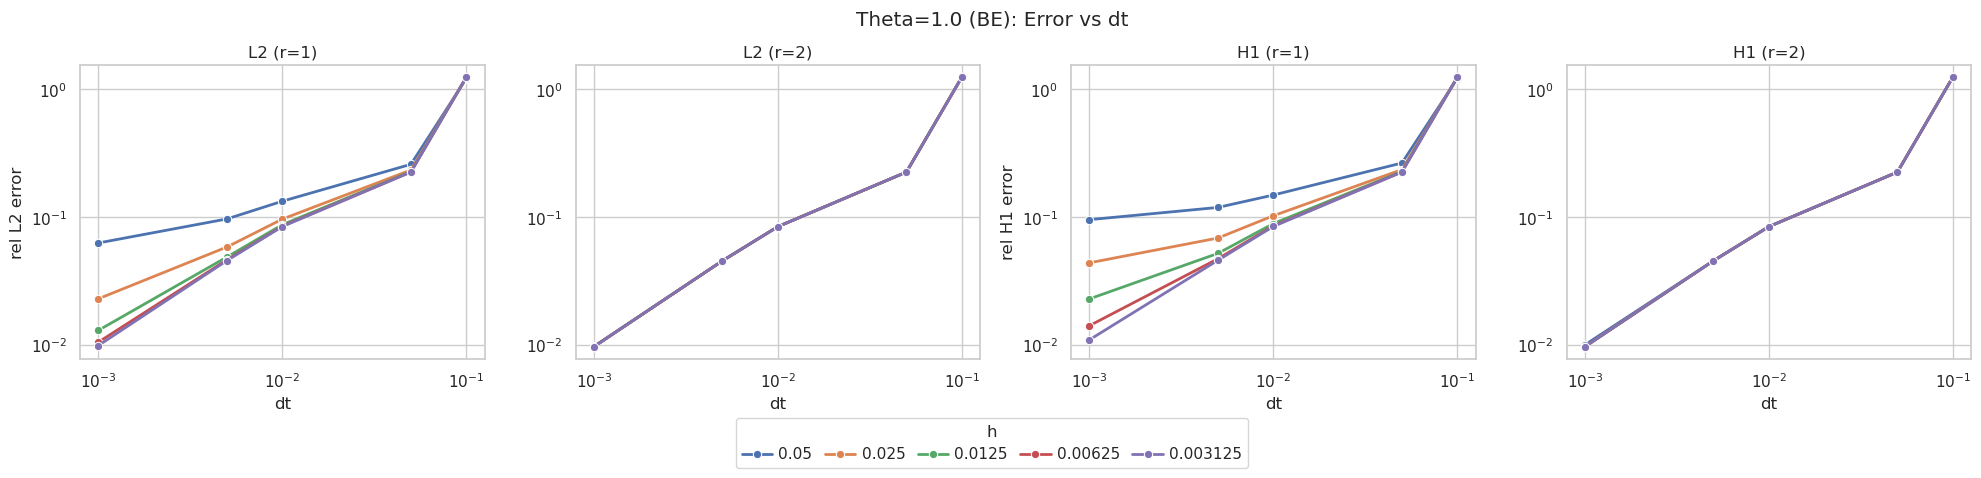

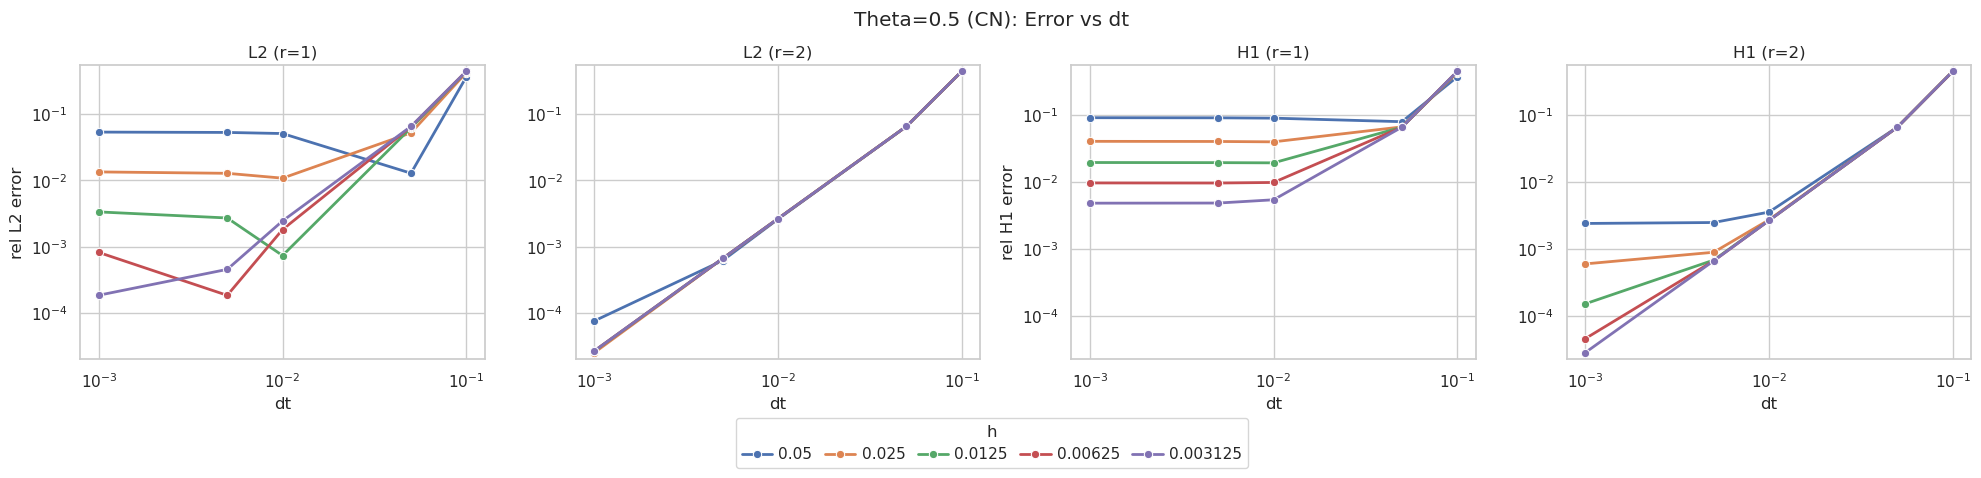

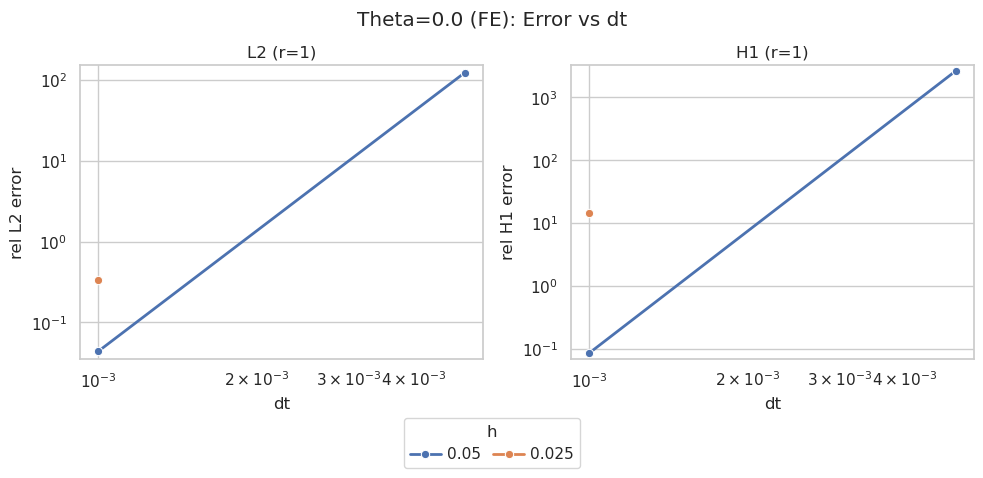

In [17]:
# Line charts for Theta subsets
figs_be = plot_lines_by_r(df_theta_BE, 'Theta=1.0 (BE)')
print()
figs_cn = plot_lines_by_r(df_theta_CN, 'Theta=0.5 (CN)')
print()
figs_fe = plot_lines_by_r(df_theta_FE, 'Theta=0.0 (FE)')

In [18]:
# # Heatmaps for Theta subsets
# plot_heatmaps(df_theta_BE, 'Theta=1.0 (BE)')
# print()
# plot_heatmaps(df_theta_CN, 'Theta=0.5 (CN)')
# print()
# plot_heatmaps(df_theta_FE, 'Theta=0.0 (FE)')